In [7]:
import numpy as np
from scipy.special import gamma
import matplotlib.pyplot as plt

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=20)
plt.rc('axes', labelsize=25, titlesize=20, labelpad=20)  # Adjusting axes parameters
plt.rc('xtick', labelsize=20)  # Adjusting xtick parameters
plt.rc('ytick', labelsize=20)  # Adjusting ytick parameters


In [8]:
def normalization_Student(d, dof, shape):
    return (gamma(dof/2) * ((dof * np.pi)**(d/2)) * np.sqrt(np.linalg.det(shape)) ) / gamma((dof+d)/2)

In [9]:
def alpha_entropy_p(d, dof_p, shape_p, dof):
    alpha = 1 + 2 / (dof + d)
    dof_alpha = dof_p + 2 * (dof_p + d) / (dof + d)
    shape_alpha = (dof_p / dof_alpha) * shape_p
    
    return -0.5*(dof+d)*(np.log(normalization_Student(d, dof_alpha, shape_alpha)) - alpha*np.log(normalization_Student(d,dof_p,shape_p)))

In [10]:
def optimal_Renyi(d, dof_target, shape_target, dof_approx):
    alpha = 1 + 2 / (dof_approx + d)
    dof_alpha = dof_target + 2 * (dof_target + d) / (dof_approx + d)
    shape_alpha = (dof_target / dof_alpha) * shape_target
    shape_approx = (dof_target / (dof_alpha - 2))*shape_target
    
    alpha_entropy_target = alpha_entropy_p(d, dof_target, shape_target, dof_approx)
    alpha_entropy_proposal = alpha_entropy_p(d, dof_approx, shape_approx, dof_approx)
    return alpha_entropy_proposal - alpha_entropy_target

In [11]:
def matrix_condition(d,cond):
    #returns a symmetric positive definite matrix of size d with condition number cond
    y = np.random.uniform(-1,1,d)
    Y = np.eye(d) - ( 2 / sum(y**2) )*np.outer(y,y)
    D = np.diag([ np.exp( (i/(d-1)) * np.log(cond)) for i in range(d)])
    return Y @ D @ Y

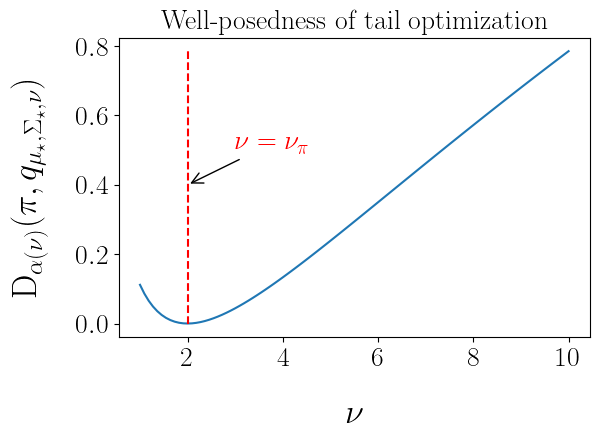

In [12]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

d = 5
shape_target = matrix_condition(d,10)
dof_target = 2
nb_dof_test = 100

dof_prop_test = np.linspace(1, 10, nb_dof_test)
res = []
for i in range(nb_dof_test):
    res.append(optimal_Renyi(d, dof_target, shape_target, dof_prop_test[i]))

plt.plot(dof_prop_test, res)
plt.vlines(dof_target, ymin = 0.0, ymax = res[nb_dof_test-1], color='red', linestyle='--')
plt.xlabel(r'$ \nu $')
plt.ylabel(r'$\mathrm{D}_{\alpha(\nu)}(\pi, q_{\mu_{\star}, \Sigma_{\star}, \nu}) $')
plt.title(r"Well-posedness of tail optimization")

# Adding a LaTeX annotation
plt.annotate(r'$\nu = \nu_{\pi}$', (dof_target, 0.4),
             xytext=(dof_target + 1, 0.5),
             arrowprops=dict(facecolor='red', arrowstyle='->'),
             fontsize=20, color='red')

plt.tight_layout()

plt.savefig('./results/tail_wellposedness.pdf', bbox_inches='tight')

In [14]:
from emukit.core import ContinuousParameter, ParameterSpace
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.bayesian_optimization.acquisitions import NegativeLowerConfidenceBound
from emukit.core.optimization import GradientAcquisitionOptimizer
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
import GPy

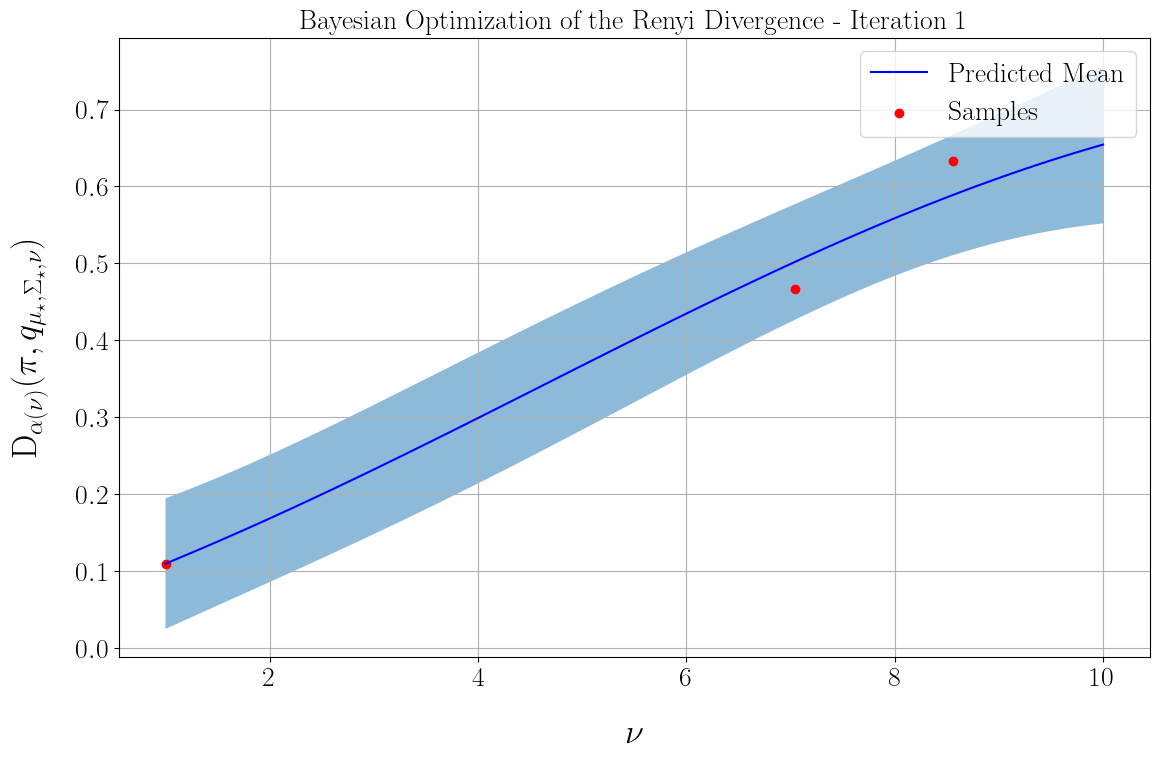

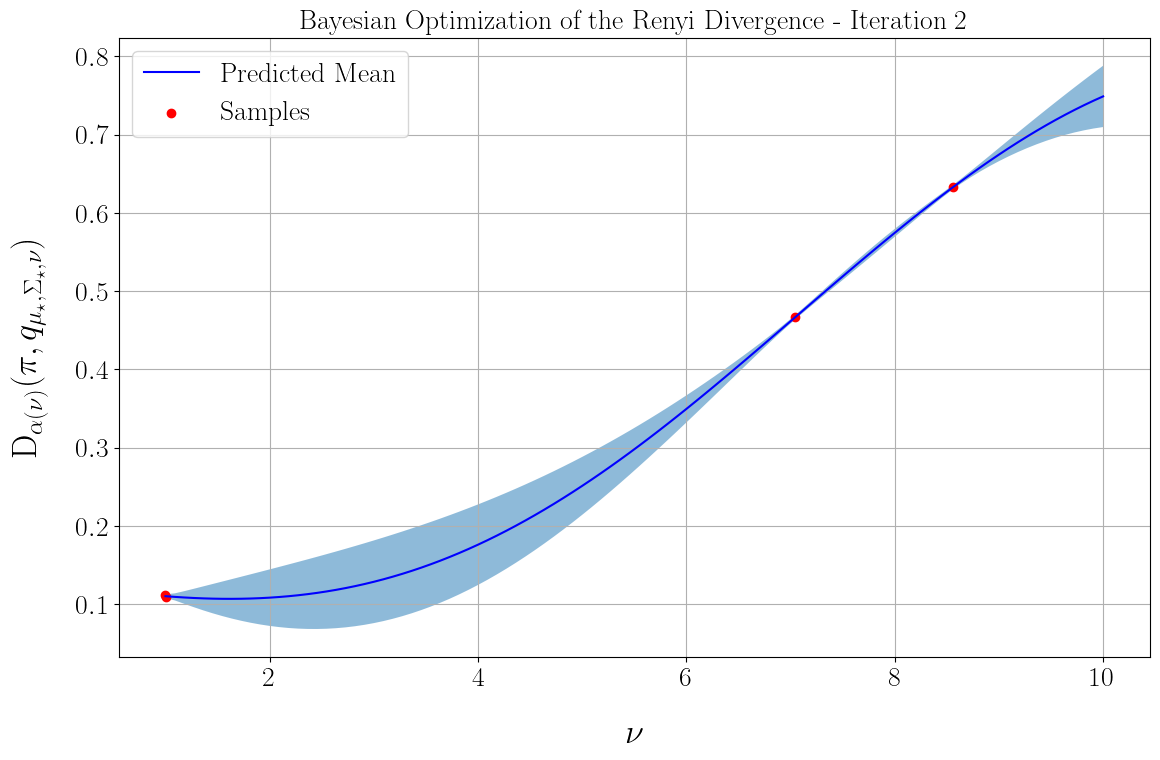

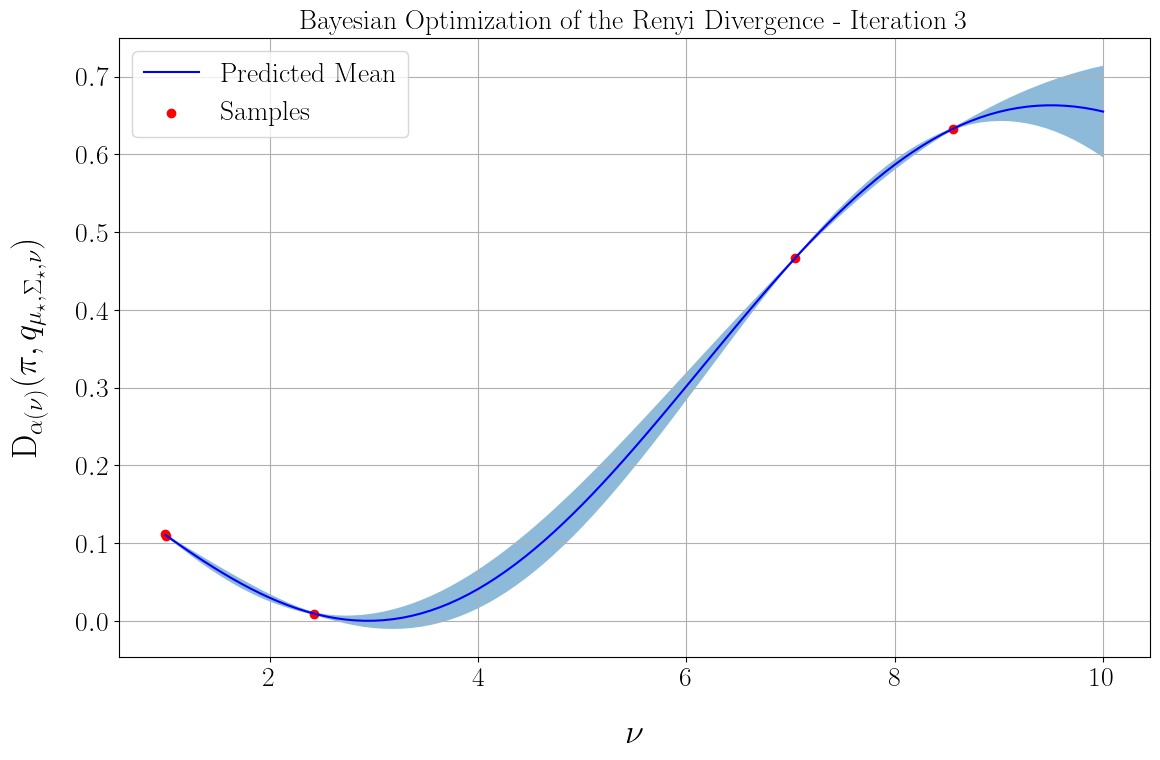

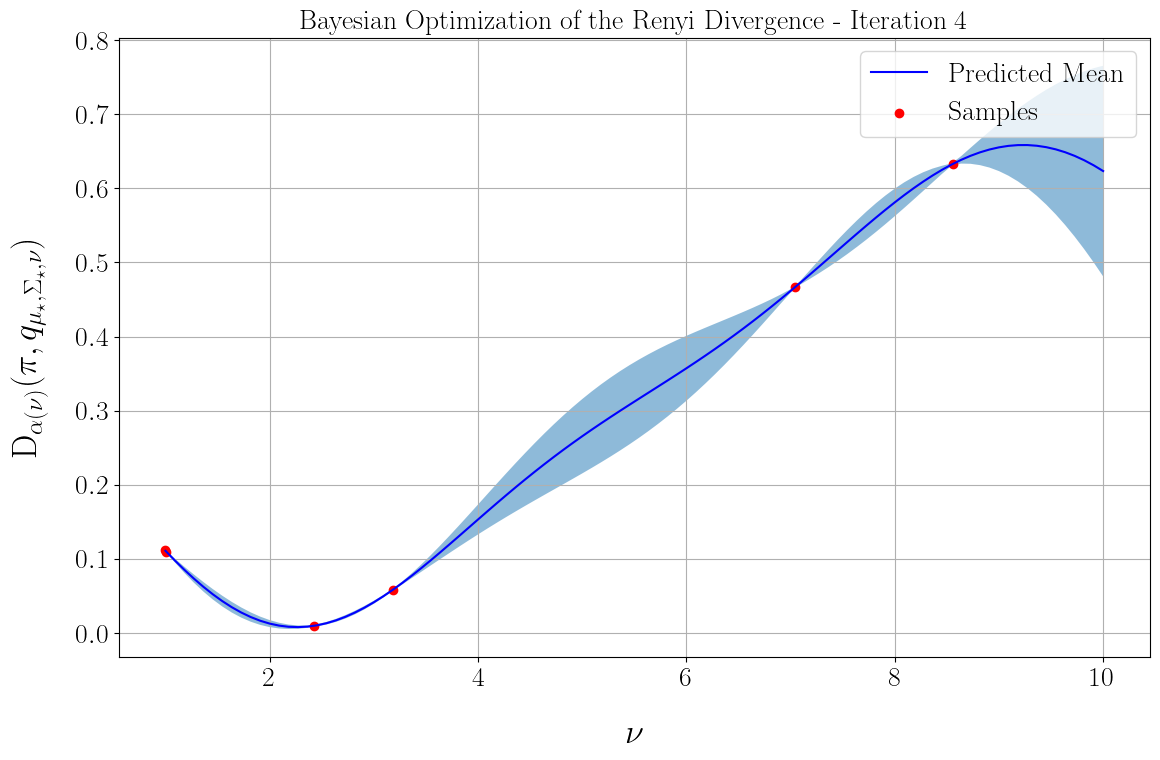

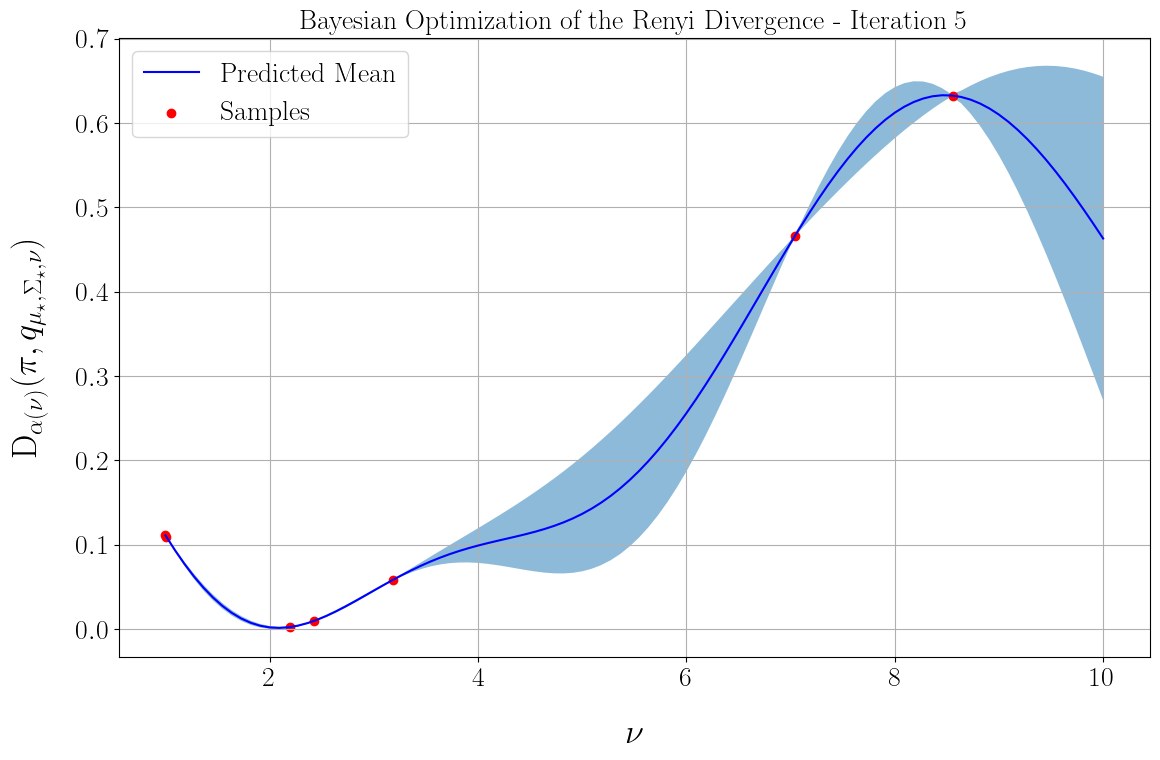

In [21]:
import numpy as np
import GPy
from emukit.core import ContinuousParameter, ParameterSpace
from emukit.bayesian_optimization.acquisitions import NegativeLowerConfidenceBound
from emukit.core.optimization import GradientAcquisitionOptimizer
from emukit.model_wrappers import GPyModelWrapper
import matplotlib.pyplot as plt

# [Previous code definitions for optimal_Renyi and other functions]

d = 5
shape_target = matrix_condition(d,10)
dof_target = 2

# Define the objective function to minimize
def objective_function(x):
    dof_prop = x
    return optimal_Renyi(d, dof_target, shape_target, dof_prop)

# Define the parameter space
dof_proposal_space = ParameterSpace([ContinuousParameter('nu', 1, 10)])

# Initial random points
x_init = np.random.rand(2, 1) * 9 + 1
y_init = np.array([objective_function(x) for x in x_init]).reshape(-1, 1)

# Define the model
model_gpy = GPy.models.GPRegression(x_init, y_init)
model_emukit = GPyModelWrapper(model_gpy)

# Iterative Bayesian Optimization
num_iterations = 5

for i in range(num_iterations):
    # Define the acquisition function and optimizer
    acquisition = NegativeLowerConfidenceBound(model_emukit)
    optimizer = GradientAcquisitionOptimizer(dof_proposal_space)

    # Optimize the acquisition function to get new point
    x_new, _ = optimizer.optimize(acquisition)

    # Evaluate the objective function at the new point
    y_new = np.array([[objective_function(x_new.item())]])

    # Update the model with the new data point
    model_emukit.set_data(np.vstack([model_emukit.X, x_new]), np.vstack([model_emukit.Y, y_new]))
    model_emukit.optimize()

    # Visualization at each iteration
    x_test = np.linspace(1, 10, 100)[:, None]
    y_mean, y_var = model_emukit.predict(x_test)

    plt.figure(figsize=(12, 8))
    plt.plot(x_test, y_mean, 'b-', label='Predicted Mean')
    plt.fill_between(x_test[:, 0], y_mean[:, 0] - np.sqrt(y_var)[:, 0], y_mean[:, 0] + np.sqrt(y_var)[:, 0], alpha=0.5)
    plt.scatter(model_emukit.X, model_emukit.Y, color='red', label='Samples')
    plt.xlabel(r'$ \nu $')
    plt.ylabel(r'$\mathrm{D}_{\alpha(\nu)}(\pi, q_{\mu_{\star}, \Sigma_{\star}, \nu}) $')
    plt.title(f'Bayesian Optimization of the Renyi Divergence - Iteration {i+1}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

